In [78]:
import numpy as np
import pandas as pd
import torch


# 70. 単語ベクトルの和による特徴量

In [79]:
df_train = pd.read_table("../output/section6/train.feature.txt")
df_valid = pd.read_table("../output/section6/valid.feature.txt")
df_test = pd.read_table("../output/section6/test.feature.txt")

In [80]:
df_train.head()

,Unnamed: 0,ID,PROCESSED_TITLE,CATEGORY
0,9388,205737,is it worth making the amazing spider man 0,e
1,8260,182926,lupita nyong o s met gala 0 dress takes the th...,e
2,7391,26499,obama to appear on the ellen show to talk obam...,e
3,7583,107422,matthew tolmach matthew tolmach spider man ...,e
4,4345,24294,italy factors to watch on march 0,b


In [81]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

In [82]:
model['0'].shape

(300,)

In [96]:
(np.ones(3)/3).dtype

dtype('float64')

In [105]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def hoge(x):
    x_tmp = x.strip()
    words = x_tmp.split()
    vec_sum = np.zeros(300, dtype=np.float32)
    vec_count = 0
    for word in words:
        if word in stop_words:
            continue
        try:
            vec = model[word]
        except KeyError:
            continue
            
        vec_sum += vec
        vec_count += 1
        
    return (vec_sum/vec_count).astype(np.float32)
            
            

In [106]:
df_train["VEC_AVG"] = df_train["PROCESSED_TITLE"].apply(lambda x: hoge(x))
df_valid["VEC_AVG"] = df_valid["PROCESSED_TITLE"].apply(lambda x: hoge(x))
df_test["VEC_AVG"] = df_test["PROCESSED_TITLE"].apply(lambda x: hoge(x))

In [111]:
# torch.tensor(df_train["VEC_AVG"])

tensor([[ 0.1328,  0.0442, -0.0108,  ..., -0.0277, -0.0538,  0.0098],
        [ 0.0738,  0.0238, -0.0055,  ..., -0.0549, -0.0256,  0.1049],
        [ 0.0135, -0.0295,  0.0053,  ..., -0.0696,  0.0711, -0.0444],
        ...,
        [ 0.0987, -0.0088, -0.0353,  ...,  0.0042,  0.1137,  0.1796],
        [-0.0012,  0.0785, -0.1167,  ...,  0.0491,  0.1383,  0.0046],
        [ 0.0333,  0.0323, -0.0288,  ...,  0.0768, -0.0453,  0.0223]])

In [86]:
category_label_dict = {
    "b": 0,
    "t": 1,
    "e": 2,
    "m": 3,
}  

In [87]:
df_train["LABEL"] = df_train["CATEGORY"].apply(lambda x: category_label_dict[x])
df_valid["LABEL"] = df_valid["CATEGORY"].apply(lambda x: category_label_dict[x])
df_test["LABEL"] = df_test["CATEGORY"].apply(lambda x: category_label_dict[x])

In [88]:
df_train["LABEL"].value_counts()

0    3672
2    3106
1     919
3     490
Name: LABEL, dtype: int64

In [62]:
df_train[["ID", "VEC_AVG", "LABEL"]].to_csv('../output/section8/train.tsv', sep='\t')
df_valid[["ID", "VEC_AVG", "LABEL"]].to_csv('../output/section8/valid.tsv', sep='\t')
df_test[["ID", "VEC_AVG", "LABEL"]].to_csv('../output/section8/test.tsv', sep='\t')

# 71. 単層ニューラルネットワークによる予測

In [63]:
df_train = pd.read_table('../output/section8/train.tsv')
df_valid = pd.read_table('../output/section8/valid.tsv')
df_test = pd.read_table('../output/section8/test.tsv')

In [114]:
torch.tensor(df_train["VEC_AVG"]).shape

torch.Size([8187, 300])

In [119]:
x_train = torch.tensor(df_train["VEC_AVG"])
x_valid = torch.tensor(df_valid["VEC_AVG"])
x_test = torch.tensor(df_test["VEC_AVG"])

y_train = torch.tensor(df_train["LABEL"])
y_valid = torch.tensor(df_valid["LABEL"])
y_test = torch.tensor(df_test["LABEL"])

In [120]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [121]:
slp_model = SLPNet(300, 4)
y_hat_1 = torch.softmax(slp_model.forward(x_train[:3]), dim=-1)
print(y_hat_1)

tensor([[0.2986, 0.5379, 0.1399, 0.0236],
        [0.0909, 0.0849, 0.8213, 0.0029],
        [0.0443, 0.0669, 0.8642, 0.0245]], grad_fn=<SoftmaxBackward>)


# 72. 損失と勾配の計算

In [123]:
criterion = nn.CrossEntropyLoss()
l_1 = criterion(slp_model(x_train[:4]), y_train[:4])
slp_model.zero_grad()
l_1.backward()

print(f"loss: {l_1:.3f}")
print(f"grad:{slp_model.fc.weight.grad}")

loss: 0.796
grad:tensor([[ 0.0158,  0.0314,  0.0041,  ..., -0.0226, -0.0026,  0.0154],
        [ 0.0198,  0.0069, -0.0013,  ..., -0.0067, -0.0065,  0.0032],
        [-0.0366, -0.0394, -0.0029,  ...,  0.0306,  0.0090, -0.0189],
        [ 0.0011,  0.0012,  0.0002,  ..., -0.0013,  0.0001,  0.0003]])


# 73. 確率的勾配降下法による学習

In [124]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
 
    def __len__(self):
        return len(self.y)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
    
dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)
dataset_test = NewsDataset(x_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [127]:
spl_model = SLPNet(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(spl_model.parameters(), lr=1e-1)

epochs = 10
for epoch in range(epochs):
    spl_model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        outputs = spl_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    loss_train = loss_train / i
    
    spl_model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = spl_model(inputs)
        loss_valid = criterion(outputs, labels)
        
    print(f"epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}")

epoch: 1, loss_train: 0.5724, loss_valid: 0.0123
epoch: 2, loss_train: 0.3754, loss_valid: 0.0063
epoch: 3, loss_train: 0.3373, loss_valid: 0.0078
epoch: 4, loss_train: 0.3180, loss_valid: 0.0107
epoch: 5, loss_train: 0.3044, loss_valid: 0.0142
epoch: 6, loss_train: 0.2954, loss_valid: 0.0040
epoch: 7, loss_train: 0.2885, loss_valid: 0.0120
epoch: 8, loss_train: 0.2826, loss_valid: 0.0073
epoch: 9, loss_train: 0.2780, loss_valid: 0.0052
epoch: 10, loss_train: 0.2750, loss_valid: 0.0035


# 74. 正解率の計測

In [128]:
def calc_acc(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return correct / total

In [129]:
acc_train = calc_acc(spl_model, dataloader_train)
acc_test = calc_acc(spl_model, dataloader_test)
print(f"acc train: {acc_train:.3f}")
print(f"acc test: {acc_test:.3f}")

acc train: 0.911
acc test: 0.882


# 75. 損失と正解率のプロット
# 76. チェックポイント
# 77. ミニバッチ化

In [130]:
def calc_loss_and_acc(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return loss / len(loader), correct / total

In [142]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, epochs):
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    log_train = []
    log_valid = []
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        loss_train, acc_train = calc_loss_and_acc(model, criterion, dataloader_train)
        loss_valid, acc_valid = calc_loss_and_acc(model, criterion, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])
        
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'../output/section8/checkpoint{epoch + 1}.pt')
        
        end_time = time.time()
        
        print(f"epoch: {epoch}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f} time: {end_time - start_time:.4f} sec")
        
    return {'train': log_train, 'valid': log_valid}
        
slp_model = SLPNet(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp_model.parameters(), lr=1e-1)
logs = []

for batch_size in [2 ** i for i in range(11)]:
    print(f'batch size: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, slp_model, criterion, optimizer, 1)
    logs.append(log)


batch size: 1
epoch: 0, loss_train: 0.3889, accuracy_train: 0.8665, loss_valid: 0.4075, accuracy_valid: 0.8622 time: 4.2769 sec
batch size: 2
epoch: 0, loss_train: 0.3519, accuracy_train: 0.8788, loss_valid: 0.3713, accuracy_valid: 0.8759 time: 2.4611 sec
batch size: 4
epoch: 0, loss_train: 0.3413, accuracy_train: 0.8831, loss_valid: 0.3638, accuracy_valid: 0.8749 time: 1.7013 sec
batch size: 8
epoch: 0, loss_train: 0.3361, accuracy_train: 0.8858, loss_valid: 0.3605, accuracy_valid: 0.8788 time: 0.8756 sec
batch size: 16
epoch: 0, loss_train: 0.3345, accuracy_train: 0.8871, loss_valid: 0.3585, accuracy_valid: 0.8788 time: 0.7459 sec
batch size: 32
epoch: 0, loss_train: 0.3332, accuracy_train: 0.8876, loss_valid: 0.3578, accuracy_valid: 0.8798 time: 0.4208 sec
batch size: 64
epoch: 0, loss_train: 0.3326, accuracy_train: 0.8880, loss_valid: 0.3576, accuracy_valid: 0.8798 time: 0.3991 sec
batch size: 128
epoch: 0, loss_train: 0.3324, accuracy_train: 0.8880, loss_valid: 0.3574, accuracy_va

epoch: 0, loss_train: 1.0005, accuracy_train: 0.6417, loss_valid: 1.0035, accuracy_valid: 0.6315 time: 0.6148 sec
epoch: 1, loss_train: 0.8649, accuracy_train: 0.6961, loss_valid: 0.8679, accuracy_valid: 0.6960 time: 0.3546 sec
epoch: 2, loss_train: 0.7808, accuracy_train: 0.7243, loss_valid: 0.7860, accuracy_valid: 0.7146 time: 0.3251 sec
epoch: 3, loss_train: 0.7197, accuracy_train: 0.7385, loss_valid: 0.7269, accuracy_valid: 0.7292 time: 0.3982 sec
epoch: 4, loss_train: 0.6726, accuracy_train: 0.7561, loss_valid: 0.6815, accuracy_valid: 0.7429 time: 0.4447 sec
epoch: 5, loss_train: 0.6354, accuracy_train: 0.7687, loss_valid: 0.6454, accuracy_valid: 0.7576 time: 0.4495 sec
epoch: 6, loss_train: 0.6043, accuracy_train: 0.7792, loss_valid: 0.6163, accuracy_valid: 0.7732 time: 0.3924 sec
epoch: 7, loss_train: 0.5793, accuracy_train: 0.7884, loss_valid: 0.5925, accuracy_valid: 0.7859 time: 0.5294 sec
epoch: 8, loss_train: 0.5578, accuracy_train: 0.7959, loss_valid: 0.5715, accuracy_valid

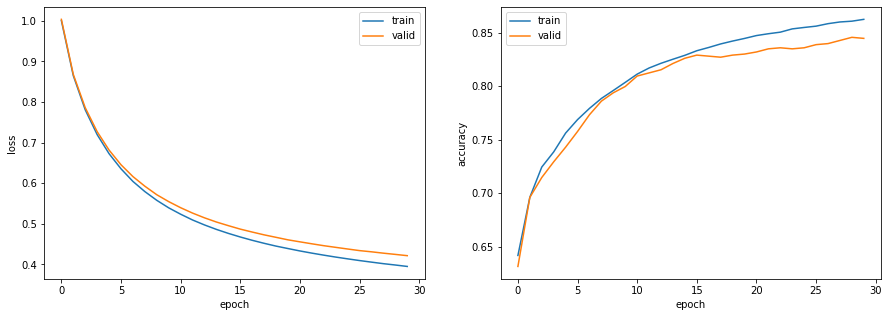

In [144]:
slp_model = SLPNet(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp_model.parameters(), lr=1e-1)
logs = train_model(dataset_train, dataset_valid, 32, slp_model, criterion, optimizer, 30)
log_train, log_valid = logs["train"], logs["valid"]

from matplotlib import pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 79. 多層ニューラルネットワーク